In [1]:
%pylab inline
import numpy as np
import pandas as pd

def read_swept_average(*, path, aperture_time, dwell_time, dwell_throwaway, dwell_settle):   
    dwell_samples = int(dwell_time/aperture_time)
    
    raw = np.fromfile(path, dtype='float32')
    raw = raw[:(raw.size//(dwell_samples+2))*(2+dwell_samples)]

    spectrum = pd.DataFrame(raw.reshape(raw.size//(2+dwell_samples),2+dwell_samples)[:,1:]).reset_index()
    del raw
    spectrum.columns = ['Time', 'Frequency'] + list(range(dwell_samples))
    frequency_count = spectrum.Frequency.unique().size

    spectrum.Time = dwell_time*frequency_count*np.floor(spectrum.Time/frequency_count)
    spectrum.Frequency /= 1e6
    spectrum.Frequency = spectrum.Frequency.round().astype(int)
    spectrum = spectrum.set_index(['Time', 'Frequency'])

    # Ettus USRPs output 0 as an "invalid" sentinel
    spectrum = spectrum.replace(0,np.nan) # specific to Ettus USRPs? They seem to give '0' until 

    # the actual hardware synchronization is loose. invalid and nan values may intermittently
    # continue for up to a couple hundred ms. this fills in everything through the final
    # nan value with nan. later code will interpret this data to ignore.
    correction = np.cumsum(spectrum.shift(dwell_throwaway, axis=1).values[:,::-1],axis=1)[:,::-1]*0
    spectrum.values[:] += correction
    spectrum.values[:,:dwell_settle] = np.nan
    
    # for interactive use, make these global
    globals().update(
        path=path,
        aperture_time=aperture_time,
        dwell_time=dwell_time,
        dwell_samples=dwell_samples,
        dwell_throwaway=dwell_throwaway,
        dwell_settle=dwell_settle
    )
    
    return spectrum

def plot_frequency_stats(by_sweep, fcs, name):
    fig,axs = subplots(1,len(fcs),sharey=True,sharex=True, figsize=(12,4))
    
    if not hasattr(axs, '__len__'):
        axs = [axs]

    for fc, ax in zip(fcs, axs):
        y2 = by_sweep.loc[:,('Min',fc)]
        y1 = by_sweep.loc[:,('Max',fc)]
        ax.fill_between(x=by_sweep.index,
                        y1=y1,
                        y2=y2,
                        where=y1>y2,
                        facecolor='green', alpha=0.2, interpolate=True)
        by_sweep.loc[:,('Mean',fc)].plot(ax=ax,color='green')
        ax.set_title(f'{fc} MHz')
        if ax is axs[0]:
            ax.set_ylabel('Average power in 1 ms (dB A.U.)')
        if ax is axs[len(axs)//2]:
            ax.set_xlabel('Time elapsed (s)')
        else:
            ax.set_xlabel('')
        if ax is axs[-1]:
            ax.legend(['Mean','Extrema'], title=f'In {dwell_time:0.1f}s', loc='best')

    fig.suptitle(name)
    savefig(f'{name}.pdf')
    return fig

Populating the interactive namespace from numpy and matplotlib


the analysis requires a few parameters:
- `path`: path to a data file output from the power sweep acquisition flowgraph
- `aperture_time`: the integration time for each sample of each dwell_time
- `dwell_time`: the time acquisition spends at each frequency step
- `dwell_settle`: the minimum number of `aperture_time` samples that must elapse before data can be valid
- `dwell_throwaway`: number of (potentially transient) initial samples to ignore after the dwell produces valid (non-NaN) samples

In [18]:
# spectrum = read_swept_average(
#     path = r'c:\users\dan\spectrum_2020-04-21_12h23m13s.dat',
#     dwell_time = 0.5, # s
#     aperture_time = 1e-3,
#     dwell_throwaway = 3,
#     dwell_settle = 60,
# )

spectrum = read_swept_average(
    path = r'c:\users\dan\2020-04-22_12h53m35s_aperture=1e-05_gain=45.dat',
    dwell_time = 0.5, # s
    aperture_time = 10e-6,
    dwell_throwaway = 3,
    dwell_settle = 60,
)

it's useful to check that the acquisition center frequency has changed, and to verify that there are no obvious detector transients in the acquired samples.

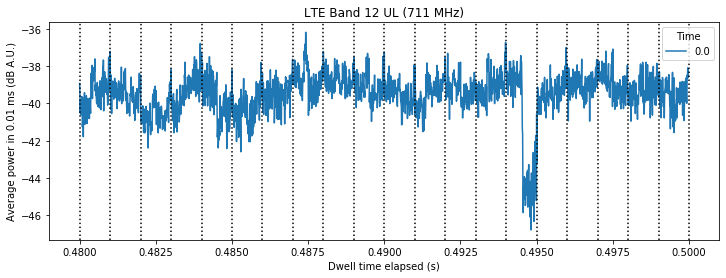

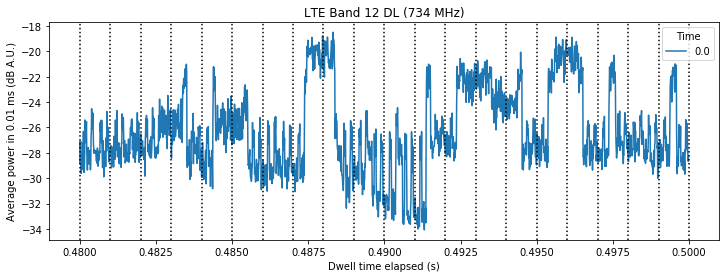

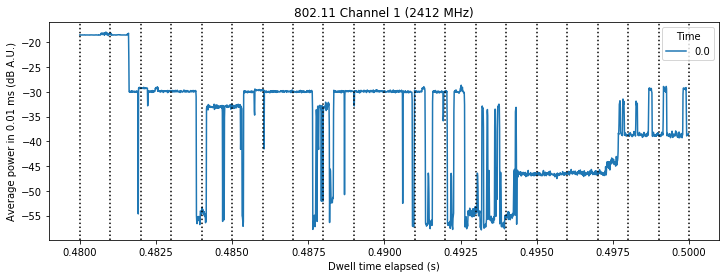

In [39]:
def plot_dwell_slices(spectrum, fc, name, *, count=5, time_start=None, time_end=None):
    fig,ax = subplots(1,1,sharey=True,sharex=True, figsize=(12,4))
    spectrum_slice = 10*log10(spectrum.reset_index().query(f'Frequency == {fc}').set_index('Time').drop('Frequency', axis=1))
    spectrum_slice.columns = spectrum_slice.columns.astype(float) * aperture_time
    spectrum_slice.T.loc[time_start:time_end].iloc[:,::spectrum_slice.shape[0]//count].plot(ax=ax)
    xlabel('Dwell time elapsed (s)')
    ylabel(f'Average power in {aperture_time*1e3} ms (dB A.U.)')
    title(name)
    return spectrum_slice.T

sslice = plot_dwell_slices(spectrum, 711, 'LTE Band 12 UL (711 MHz)', count=1, time_start=0.48)
for x in np.arange(.48,.5,.001):
    axvline(x,linestyle=':',color='black')
savefig(r'c:\users\dan\lte_band_12_ul_10us_aperture.pdf')
savefig(r'c:\users\dan\lte_band_12_ul_10us_aperture.jpg',dpi=300)

sslice = plot_dwell_slices(spectrum, 734, 'LTE Band 12 DL (734 MHz)', count=1, time_start=0.48)
for x in np.arange(.48,.5,.001):
    axvline(x,linestyle=':',color='black')
savefig(r'c:\users\dan\lte_band_12_dl_10us_aperture.pdf')
savefig(r'c:\users\dan\lte_band_12_dl_10us_aperture.jpg',dpi=300)

sslice = plot_dwell_slices(spectrum, 2412, '802.11 Channel 1 (2412 MHz)', count=1, time_start=0.48)
for x in np.arange(.48,.5,.001):
    axvline(x,linestyle=':',color='black')
savefig(r'c:\users\dan\wlan_channel__10us_aperture.pdf')
savefig(r'c:\users\dan\lte_band_12_ul_10us_aperture.jpg',dpi=300)


In [26]:
spectrum.index

MultiIndex([( 0.0,  704),
            ( 0.0,  711),
            ( 0.0,  734),
            ( 0.0,  741),
            ( 0.0, 2412),
            ( 0.0, 2437),
            ( 0.0, 2462),
            ( 3.5,  704),
            ( 3.5,  711),
            ( 3.5,  734),
            ( 3.5,  741),
            ( 3.5, 2412),
            ( 3.5, 2437),
            ( 3.5, 2462),
            ( 7.0,  704),
            ( 7.0,  711),
            ( 7.0,  734),
            ( 7.0,  741),
            ( 7.0, 2412),
            ( 7.0, 2437),
            ( 7.0, 2462),
            (10.5,  704),
            (10.5,  711),
            (10.5,  734)],
           names=['Time', 'Frequency'])

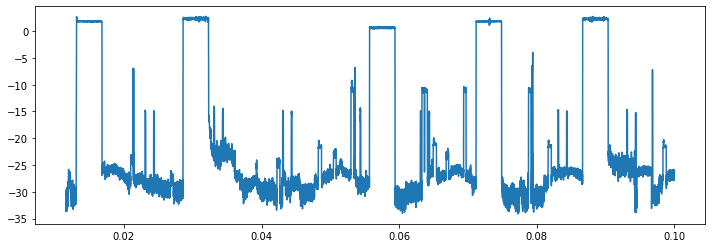

In [16]:
subslice = pd.DataFrame(sslice, index=sslice.index.values)
fig, ax = subplots(1,1,figsize=(12,4))
subslice.loc[:.1,3].plot()
xlabel('Time elapsed (s)')
ylabel('')

to explore the full dataset, we can look at statistics of each dwell window over time. as a simple example to start, here are trends in min, max, and mean for each frequency under study:

In [ ]:
stats = pd.DataFrame(dict(Min=spectrum.min(axis=1),
                          Max=spectrum.max(axis=1),
                          Mean=spectrum.mean(axis=1)))
by_sweep = (10*log10(stats)).reset_index().set_index('Time').pivot(columns='Frequency')

plot_frequency_stats(by_sweep, [704,711,782,829,844], 'LTE Uplink Bands')
plot_frequency_stats(by_sweep, [734,741,752,874,889], 'LTE Downlink Bands')
plot_frequency_stats(by_sweep, [1575], 'GPS L1')
plot_frequency_stats(by_sweep, [2412, 2417, 2422, 2427, 2432, 2437], 'ISM Band (lower)')
plot_frequency_stats(by_sweep, [2442, 2447, 2452, 2457, 2462], 'ISM Band(upper)')
plot_frequency_stats(by_sweep, [5170,5190,5210,5230], 'U-NII1 Band (lower)')
plot_frequency_stats(by_sweep, [5240,5775,5795], 'U-NII1 Band (upper)')